Course 3 Week 3 Exercise: LSTM-RNN on synthetic time series dataset

Coursera Colab link: https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%203%20Exercise%20Question.ipynb

Answers Coursera Colab link: https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%203%20Exercise%20Answer.ipynb

Lambda tf keras layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt


2.2.0-rc2


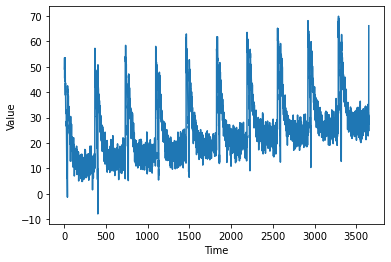

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 128
shuffle_buffer_size = 1000

plot_series(time, series)

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)


dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x : tf.expand_dims(x, axis=-1), input_shape=[None]),  # YOUR CODE HERE),
  # YOUR CODE HERE
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x : x * 10.0) # YOUR CODE HERE)

  # # Alternative Coursera:
  # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  # tf.keras.layers.Dense(1),
  # tf.keras.layers.Lambda(lambda x: x * 10.0)

])

model.summary()


optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", 'mse', 'accuracy'])
# model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9),metrics=["mae",'mse','accuracy'])


lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
94/94 [==============================] - 2s 21ms/step - loss: 20.2473 - mae: 20.7497 - mse: 524.8022 - acc

(1e-08, 0.0001, 0.0, 30.0)

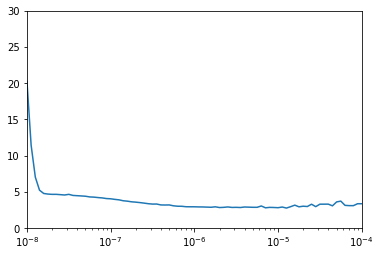

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

# FROM THIS PICK A LEARNING RATE

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)


dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x : tf.expand_dims(x, axis=-1), input_shape=[None]),  # YOUR CODE HERE),
  # YOUR CODE HERE
  tf.keras.layers.LSTM(64, return_sequences=True),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(32),
  # tf.keras.layers.Dense(40, activation='relu'),
  tf.keras.layers.Dense(1),   # no activation for mse output
  tf.keras.layers.Lambda(lambda x : x * 10.0) # YOUR CODE HERE)

  # # Alternative Coursera:
  # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  # tf.keras.layers.Dense(1),
  # tf.keras.layers.Lambda(lambda x: x * 10.0)

])

model.summary()


# optimizer = tf.keras.optimizers.SGD(lr=3e-5, momentum=0.9)
# model.compile(loss=tf.keras.losses.Huber(),
#               optimizer=optimizer,
#               metrics=["mae", 'mse', 'accuracy'])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=7.5e-6, momentum=0.9),metrics=["mae", 'mse', 'accuracy'])
                                            

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 62,369
Trainable params: 62,369
Non-trainable params: 0
____________________________________________________

In [0]:
print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


In [0]:
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20))

history = model.fit(dataset, epochs=250, verbose=1)  #, callbacks=[lr_schedule])


                                                            
# FIND A MODEL AND A LR THAT TRAINS TO AN MAE < 3              

Epoch 1/250
94/94 [==============================] - 3s 31ms/step - loss: 136.8842 - mae: 8.3949 - mse: 136.9150 - accuracy: 0.0000e+00
Epoch 2/250
94/94 [==============================] - 3s 32ms/step - loss: 97.2841 - mae: 6.9305 - mse: 97.7971 - accuracy: 0.0000e+00
Epoch 3/250
94/94 [==============================] - 3s 32ms/step - loss: 65.1934 - mae: 5.0636 - mse: 65.6869 - accuracy: 0.0000e+00
Epoch 4/250
94/94 [==============================] - 3s 32ms/step - loss: 54.4556 - mae: 4.5871 - mse: 54.8430 - accuracy: 0.0000e+00
Epoch 5/250
94/94 [==============================] - 3s 32ms/step - loss: 46.4858 - mae: 4.3053 - mse: 46.7656 - accuracy: 0.0000e+00
Epoch 6/250
94/94 [==============================] - 3s 32ms/step - loss: 40.3916 - mae: 3.9774 - mse: 40.6850 - accuracy: 0.0000e+00
Epoch 7/250
94/94 [==============================] - 3s 32ms/step - loss: 36.1675 - mae: 3.7344 - mse: 36.4857 - accuracy: 0.0000e+00
Epoch 8/250
94/94 [==============================] - 3s 32ms

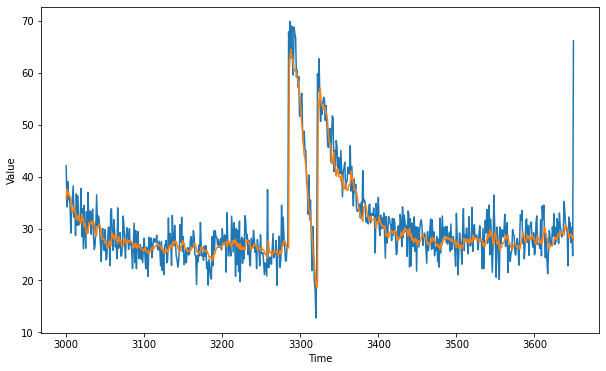

In [0]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

# YOUR RESULT HERE SHOULD BE LESS THAN 4

18.192305
2.7972035


If training curve is a bit noisy -> we start to over-fit.


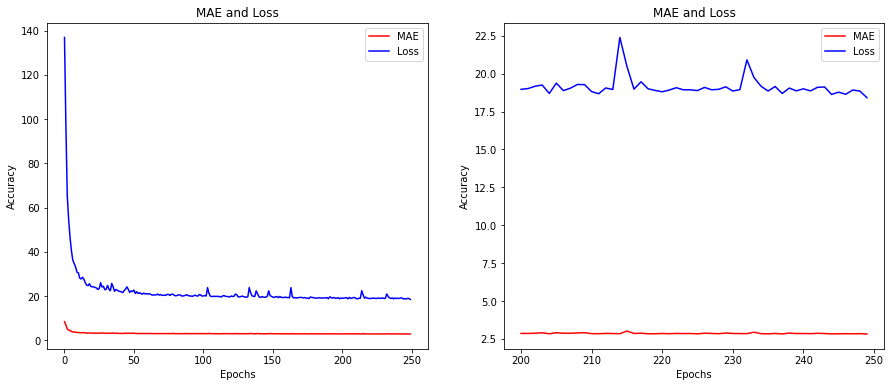

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

plt.figure(figsize=(15,6))

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.subplot(1,2,1)
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])



epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.subplot(1,2,2)
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

print('If training curve is a bit noisy -> we start to over-fit or perhaps decrease batch size.')